# Final Project - using CNN to do garbage classification

In [ ]:
# Initialization
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 1: Process the  Dataset

In [ ]:
# Extract the training and validation dataset
!unzip "/content/dataset.zip"

In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
from keras.preprocessing import image
from tqdm import tqdm

data_dir = "/content/garbage_classification/"
batch_size = 32;
# The default size of densenet is 224*224
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 15569 files belonging to 12 classes.
Using 12456 files for training.
Found 15569 files belonging to 12 classes.
Using 3113 files for validation.


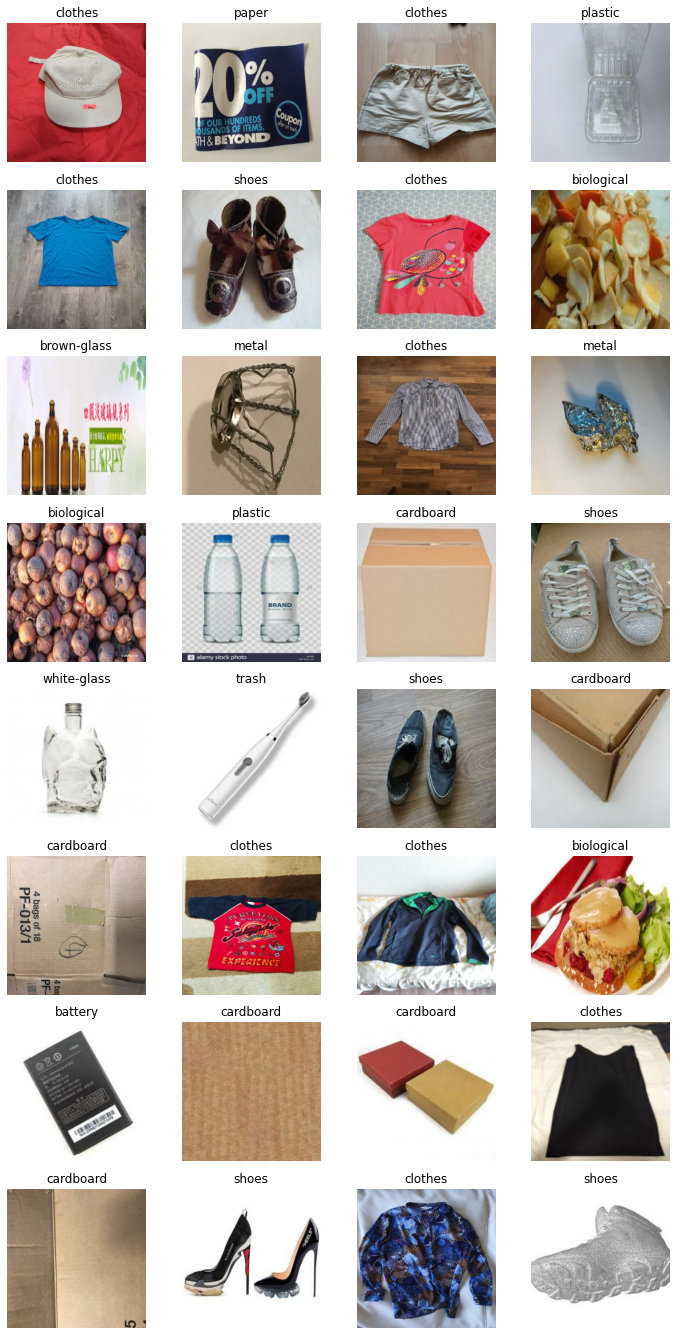

In [ ]:
# Visualize some of the train samples of one batch
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 
  'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 
  'trash', 'white-glass']
# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# Step 2: Construct our model using the Densenet Network with transfer learning



In [ ]:
# We use densenet121 as our pre-trained model
def preprocess(image, label):
    final_image = keras.applications.densenet.preprocess_input(image)
    return final_image, label

train_set_preprocessed = train_ds.map(preprocess)
valid_set_preprocessed = validation_ds.map(preprocess)

base_model = keras.applications.densenet.DenseNet121(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# 12 classes in total
output = keras.layers.Dense(12, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

29084464/29084464 [==============================] - 2s 0us/step


# Step 3: Train our model by freezing the pre-train weights and only training the top layer

In [ ]:
# Use SGD optimizer with learning rate of 0.2 and momentum of 0.9
# 10 epochs
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set_preprocessed,
                    validation_data=valid_set_preprocessed,
                    epochs=10)

Epoch 1/10
390/390 [==============================] - 67s 135ms/step - loss: 2.1228 - accuracy: 0.8977 - val_loss: 1.1074 - val_accuracy: 0.9313
Epoch 2/10
390/390 [==============================] - 48s 122ms/step - loss: 0.6174 - accuracy: 0.9593 - val_loss: 0.7180 - val_accuracy: 0.9412
Epoch 3/10
390/390 [==============================] - 49s 124ms/step - loss: 0.3927 - accuracy: 0.9672 - val_loss: 0.6875 - val_accuracy: 0.9412
Epoch 4/10
390/390 [==============================] - 49s 124ms/step - loss: 0.2895 - accuracy: 0.9705 - val_loss: 0.6431 - val_accuracy: 0.9454
Epoch 5/10
390/390 [==============================] - 48s 123ms/step - loss: 0.2374 - accuracy: 0.9744 - val_loss: 0.6469 - val_accuracy: 0.9428
Epoch 6/10
390/390 [==============================] - 48s 123ms/step - loss: 0.1992 - accuracy: 0.9767 - val_loss: 0.6324 - val_accuracy: 0.9457
Epoch 7/10
390/390 [==============================] - 50s 127ms/step - loss: 0.1755 - accuracy: 0.9789 - val_loss: 0.6124 - val_ac

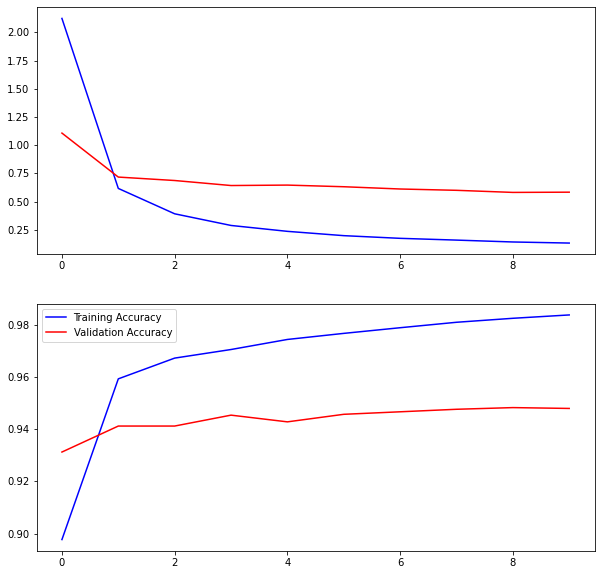

In [ ]:
# visualize the loss and accuracy for both training and validation data
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

# Step 4: Evaluate the model using validation set

In [ ]:
# get prediction value for validation set
#print(len(valid_set_preprocessed))
labels_predict=[]
true_labels=[]
for k in range(len(valid_set_preprocessed)):
  for image,label in valid_set_preprocessed.take(3):
    label_predict=model.predict(image)
    for i in range(32):
      max=0
      label_class=-1

      for j in range(len(label_predict[i])):
        if label_predict[i][j] > max:
          max = label_predict[i][j]
          label_class=j
      labels_predict.append(label_class)
    true_labels.append(label)

In [ ]:
# after we got the prediction value, we then compare it with the true value.
# we need to transfer the format of true_labels to compare with predicted labels
true_labels_trans=[]
for i in range(len(true_labels)):
  for labels in true_labels[i]:
    true_labels_trans.append(int(labels))

print("true labels:", true_labels_trans)
print("predict labels:", labels_predict)

true labels: [11, 4, 8, 3, 3, 0, 7, 1, 2, 4, 7, 4, 4, 9, 4, 4, 8, 9, 6, 4, 9, 2, 9, 4, 11, 4, 0, 9, 9, 4, 9, 4, 9, 9, 4, 4, 4, 9, 11, 9, 7, 0, 0, 9, 2, 4, 4, 7, 10, 0, 10, 7, 11, 9, 4, 4, 3, 4, 1, 4, 4, 4, 4, 6, 4, 10, 1, 9, 6, 9, 3, 4, 0, 2, 4, 1, 6, 9, 7, 7, 4, 6, 9, 4, 4, 11, 4, 10, 4, 3, 8, 9, 9, 4, 1, 9, 4, 1, 4, 4, 4, 11, 0, 0, 9, 4, 4, 9, 6, 4, 2, 11, 4, 8, 9, 4, 11, 4, 11, 4, 4, 9, 9, 5, 4, 7, 0, 9, 11, 7, 4, 6, 6, 9, 4, 4, 10, 4, 1, 1, 4, 3, 4, 9, 4, 9, 9, 9, 9, 4, 4, 11, 10, 10, 9, 4, 10, 4, 6, 4, 7, 0, 9, 2, 5, 6, 4, 4, 4, 4, 2, 10, 4, 4, 11, 4, 6, 9, 2, 11, 7, 4, 9, 9, 4, 3, 4, 8, 1, 3, 9, 9, 10, 4, 7, 4, 4, 4, 11, 3, 6, 8, 7, 9, 10, 11, 11, 4, 4, 10, 9, 4, 10, 1, 5, 4, 1, 6, 4, 9, 4, 4, 2, 4, 4, 2, 11, 4, 10, 1, 4, 4, 9, 4, 9, 4, 4, 4, 3, 4, 0, 8, 0, 9, 7, 2, 7, 7, 1, 8, 5, 4, 2, 9, 8, 4, 4, 9, 1, 2, 0, 4, 7, 8, 4, 0, 8, 3, 9, 11, 4, 9, 4, 4, 4, 9, 4, 6, 4, 7, 9, 9, 4, 4, 4, 6, 9, 9, 4, 9, 8, 10, 2, 6, 4, 4, 4, 9, 4, 4, 4, 8, 9, 4, 4, 4, 6, 9, 11, 3, 1, 7, 4, 6, 4, 3, 9, 4

In [ ]:
# create a 2D map to track the confusion matrix between each kind of garbage
confusion_matrix = [[0 for i in range(12)] for j in range(12)]

# calculate the total number of correct prediction and false prediction
same=0
dif=0
for i in range(len(true_labels_trans)):
  confusion_matrix[true_labels_trans[i]][labels_predict[i]]+=1;
  if(true_labels_trans[i]==labels_predict[i]):
    same+=1
  else:
    dif+=1
print("number of correct predictions:", same)
print("number of wrong predictions:", dif)
print("overall accuracy:", same/(same+dif))
print("confusion matrix:", confusion_matrix)

# get the prediction accuracy for each kind of garbage
single_accuracy=[]
for i in range(len(confusion_matrix)):
  single_accuracy.append(confusion_matrix[i][i]/np.sum(confusion_matrix[i]))
print("accuracy of each kind of garbage:", single_accuracy)

# print the total number of the dataset for each garbage
dataset_size=[]
for i in range(len(confusion_matrix)):
  dataset_size.append(np.sum(confusion_matrix[i]))
print("The size of each kind of garbage' dataset is:", dataset_size)

number of correct predictions: 8930
number of wrong predictions: 478
overall accuracy: 0.9491921768707483
confusion matrix: [[471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 431, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 361, 0, 0, 0, 0, 29, 0, 0, 0, 0], [0, 0, 0, 308, 0, 0, 30, 28, 0, 0, 0, 0], [0, 0, 0, 0, 3336, 0, 0, 26, 0, 29, 0, 0], [0, 0, 0, 0, 0, 271, 0, 0, 0, 0, 0, 3], [0, 0, 0, 0, 12, 0, 332, 56, 29, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 542, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 6, 0, 381, 0, 0, 51], [0, 0, 0, 0, 65, 0, 0, 0, 0, 1567, 0, 0], [0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 437, 0], [0, 0, 27, 0, 0, 0, 5, 0, 56, 0, 19, 493]]
accuracy of each kind of garbage: [1.0, 1.0, 0.9256410256410257, 0.8415300546448088, 0.9837805956944854, 0.9890510948905109, 0.7738927738927739, 1.0, 0.8698630136986302, 0.960171568627451, 0.9842342342342343, 0.8216666666666667]
The size of each kind of garbage' dataset is: [471, 431, 390, 366, 3391, 274, 429, 542, 438, 1632, 444, 600]


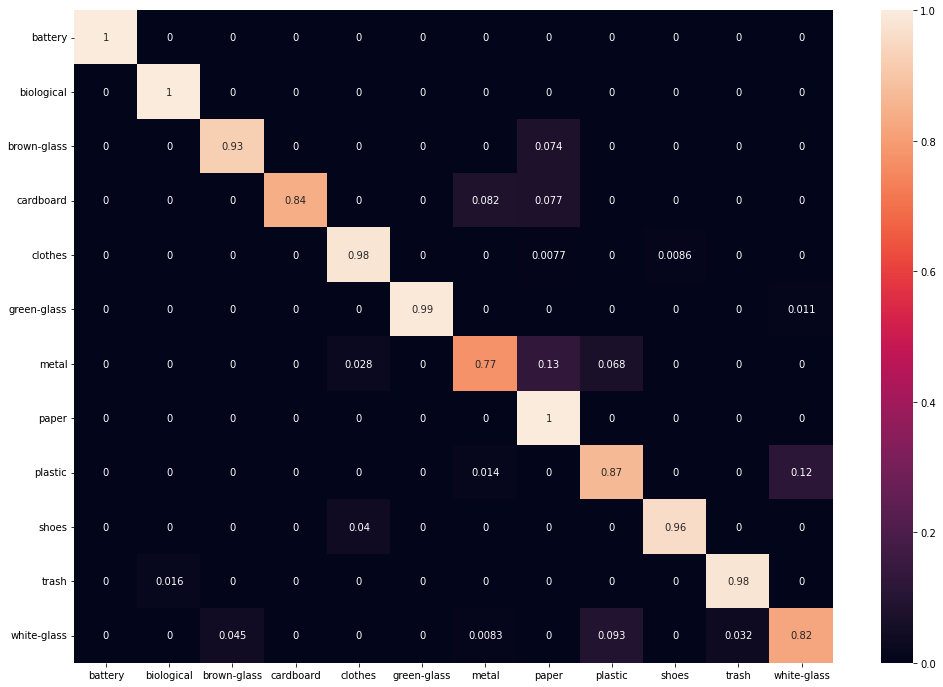

In [ ]:
# I found the confusion matrix with simply counts is not convincing because the total number of each kind of garbage is different
# So, I decide to make a confusion matrix in proportion which makes more sense
prop_matrix=[[0 for i in range(12)] for j in range(12)]
for i in range(len(confusion_matrix)):
  for j in range(len(confusion_matrix)):
    prop_matrix[i][j]=confusion_matrix[i][j]/np.sum(confusion_matrix[i])

# plot the confusion matrix(in proportion)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(prop_matrix, index = class_names,
                  columns = class_names)
plt.figure(figsize = (17,12))
sn.heatmap(df_cm, annot=True)

# Step 5: Testing the model with real life images

In [ ]:
!unzip "testing_images.zip"

In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/testing_images/",
    seed=42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
testing_ds 

Found 253 files belonging to 12 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
testing_ds_preprocessed=testing_ds.map(preprocess)
testing_ds_preprocessed

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

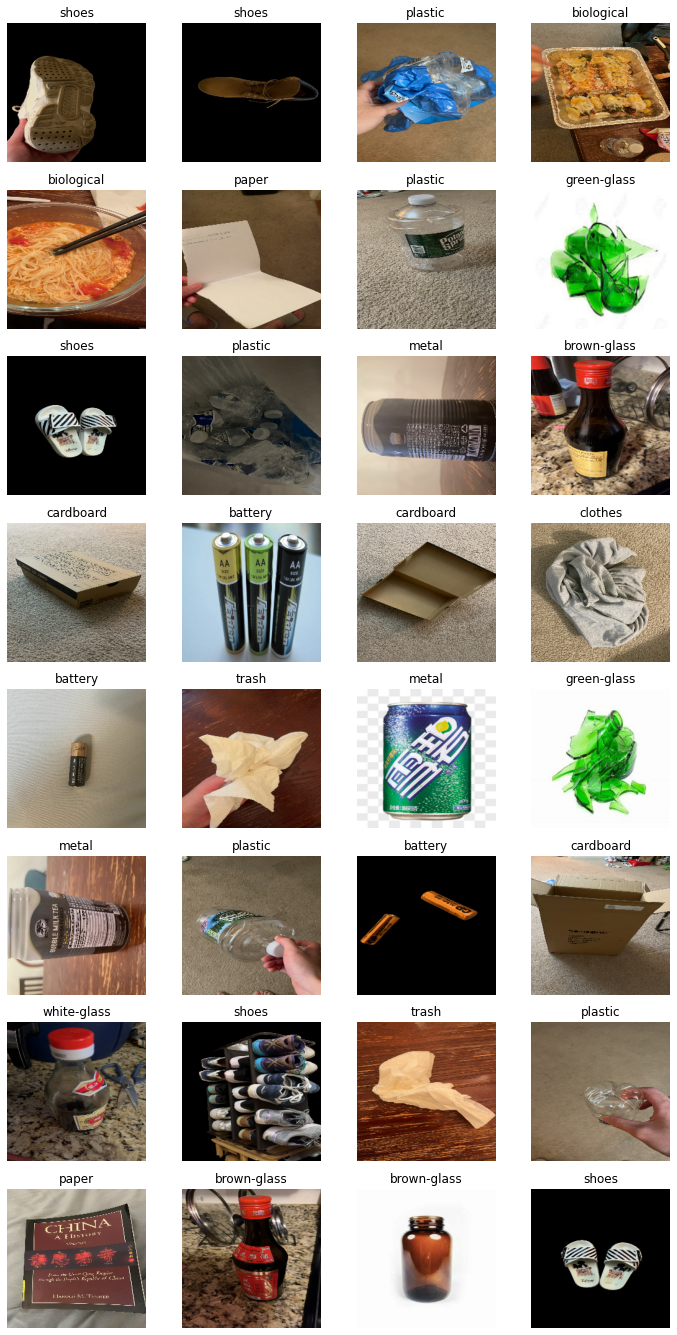

In [ ]:
# visualize the testing dataset by a single batch
testing_ds_preprocessed.take(1)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in testing_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# get prediction value for test data

labels_predict=[]
true_labels=[]
for k in range(len(testing_ds_preprocessed)):
  for image,label in testing_ds_preprocessed.take(3):
    label_predict=model.predict(image)
    for i in range(32):
      max=0
      label_class=-1

      for j in range(len(label_predict[i])):
        if label_predict[i][j] > max:
          max = label_predict[i][j]
          label_class=j
      labels_predict.append(label_class)

    true_labels.append(label)

In [ ]:
# after we got the prediction value, we then compare it with the true value.
# we need to transfer the format of true_labels to compare with predicted labels
true_labels_trans=[]
for i in range(len(true_labels)):
  for labels in true_labels[i]:
    true_labels_trans.append(int(labels))

print("true labels:", true_labels_trans)
print("predict labels:", labels_predict)

true labels: [9, 8, 9, 4, 3, 9, 2, 3, 9, 0, 4, 10, 7, 3, 0, 1, 2, 0, 7, 2, 4, 0, 11, 5, 9, 0, 6, 8, 9, 9, 5, 5, 4, 8, 6, 9, 1, 0, 9, 10, 8, 10, 3, 6, 9, 9, 1, 10, 9, 9, 0, 0, 8, 3, 7, 0, 8, 9, 8, 9, 9, 9, 11, 9, 6, 2, 2, 9, 6, 3, 1, 7, 0, 9, 3, 3, 7, 2, 0, 5, 11, 9, 8, 11, 11, 5, 9, 10, 0, 6, 9, 9, 0, 11, 6, 8, 3, 10, 6, 3, 11, 10, 6, 9, 9, 6, 3, 10, 6, 10, 9, 4, 0, 8, 9, 5, 9, 11, 9, 8, 9, 9, 6, 1, 6, 7, 1, 1, 0, 3, 6, 5, 4, 10, 4, 11, 9, 8, 9, 9, 1, 6, 3, 0, 1, 4, 7, 3, 6, 9, 8, 11, 9, 2, 3, 2, 7, 1, 5, 7, 4, 8, 0, 0, 11, 2, 3, 8, 0, 1, 6, 3, 5, 4, 4, 9, 9, 0, 11, 9, 1, 8, 3, 8, 9, 9, 8, 0, 9, 3, 9, 6, 2, 7, 1, 3, 11, 6, 4, 8, 10, 8, 6, 8, 3, 6, 11, 11, 8, 3, 4, 9, 0, 9, 0, 7, 9, 1, 4, 9, 3, 5, 9, 3, 10, 1, 11, 8, 3, 9, 0, 8, 4, 0, 9, 2, 9, 7, 1, 0, 0, 8, 8, 0, 1, 3, 4, 6, 9, 11, 6, 9, 5, 5, 9, 6, 3, 6, 6, 6, 9, 9, 4, 1, 4, 10, 3, 5, 8, 7, 6, 5, 9, 7, 0, 3, 10, 8, 10, 5, 3, 8, 4, 9, 3, 0, 4, 3, 1, 6, 10, 8, 2, 0, 5, 10, 0, 9, 8, 1, 1, 6, 6, 9, 0, 4, 0, 9, 9, 9, 2, 8, 11, 0, 1, 0, 7, 

In [ ]:
# create a 2D map to track the confusion matrix between each kind of garbage
confusion_matrix = [[0 for i in range(12)] for j in range(12)]

# calculate the total number of correct prediction and false prediction
same=0
dif=0
for i in range(len(true_labels_trans)):
  confusion_matrix[true_labels_trans[i]][labels_predict[i]]+=1;
  if(true_labels_trans[i]==labels_predict[i]):
    same+=1
  else:
    dif+=1
print("number of correct predictions:", same)
print("number of wrong predictions:", dif)
print("overall accuracy:", same/(same+dif))
print("confusion matrix:", confusion_matrix)

# get the prediction accuracy for each kind of garbage
single_accuracy=[]
for i in range(len(confusion_matrix)):
  single_accuracy.append(confusion_matrix[i][i]/np.sum(confusion_matrix[i]))
print("accuracy of each kind of garbage:", single_accuracy)

# print the total number of the dataset for each garbage
dataset_size=[]
for i in range(len(confusion_matrix)):
  dataset_size.append(np.sum(confusion_matrix[i]))
print("The size of each kind of garbage' dataset is:", dataset_size)

number of correct predictions: 607
number of wrong predictions: 161
overall accuracy: 0.7903645833333334
confusion matrix: [[66, 0, 10, 6, 0, 0, 4, 3, 0, 0, 0, 0], [0, 52, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 27, 0, 0, 3, 0, 0, 0, 0, 0, 3], [0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 54, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 40, 0, 12, 0, 0, 7], [0, 0, 0, 14, 0, 0, 0, 26, 0, 0, 0, 0], [0, 0, 0, 0, 3, 0, 0, 0, 57, 0, 0, 19], [1, 0, 0, 0, 35, 0, 2, 0, 0, 107, 16, 0], [0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 35, 1], [0, 0, 0, 0, 0, 1, 3, 0, 8, 0, 0, 27]]
accuracy of each kind of garbage: [0.7415730337078652, 0.9811320754716981, 0.8181818181818182, 1.0, 1.0, 1.0, 0.6557377049180327, 0.65, 0.7215189873417721, 0.6645962732919255, 0.813953488372093, 0.6923076923076923]
The size of each kind of garbage' dataset is: [89, 53, 33, 78, 54, 38, 61, 40, 79, 161, 43, 39]


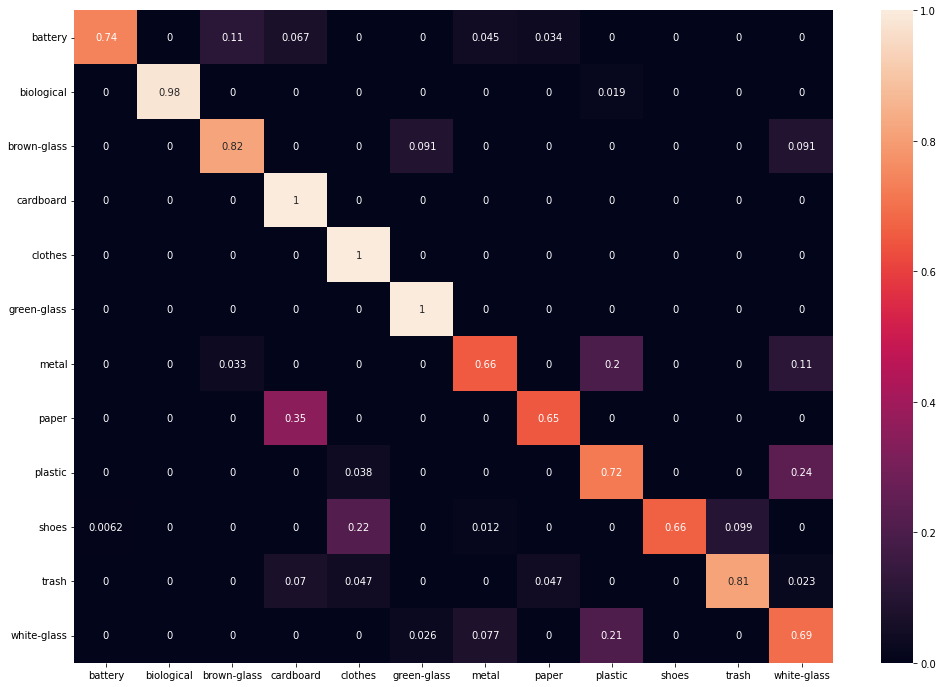

In [ ]:
# I found the confusion matrix with simply counts is not convincing because the total number of each kind of garbage is different
# So, I decide to make a confusion matrix in proportion which makes more sense
prop_matrix=[[0 for i in range(12)] for j in range(12)]
for i in range(len(confusion_matrix)):
  for j in range(len(confusion_matrix)):
    prop_matrix[i][j]=confusion_matrix[i][j]/np.sum(confusion_matrix[i])

# plot the confusion matrix(in proportion)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(prop_matrix, index = class_names,
                  columns = class_names)
plt.figure(figsize = (17,12))
sn.heatmap(df_cm, annot=True)